In [249]:
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from skimage import io, color, filters, measure

## Util functions to transform and visualize cells 

In [250]:
class Args:
    """
    Class to convert a dictionary into an object, allowing attribute-style access.

    Attributes:
        dictionary (dict): The dictionary to be converted into an object.
    """

    def __init__(self, dictionary):
        """
        Initializes the Args object with the provided dictionary.

        Parameters:
            dictionary (dict): The dictionary to be converted into an object.
        """
        self.__dict__ = dictionary

    def __getattr__(self, key):
        """
        Allows attribute-style access to dictionary values.

        Parameters:
            key (str): The key corresponding to the attribute being accessed.

        Returns:
            Any: The value associated with the key in the dictionary.

        Raises:
            AttributeError: If the key does not exist in the dictionary.
        """
        if key in self.__dict__:
            return self.__dict__[key]
        else:
            raise AttributeError(f"'DictToObject' object has no attribute '{key}'")

    def __call__(self, key):
        """
        Allows calling the object to retrieve dictionary values.

        Parameters:
            key (str): The key corresponding to the attribute being accessed.

        Returns:
            Any: The value associated with the key in the dictionary.
        """
        return self.__getattr__(key)


def t2np(t, batch_dim=False):
    """
    Convert a PyTorch tensor to a NumPy array and normalize pixel values.

    Parameters:
        t (torch.Tensor): The PyTorch tensor to be converted.

    Returns:
        numpy.ndarray: The NumPy array representation of the tensor.
    """ 
    return ((t.permute(0, 2, 3, 1) + 1) / 2).clamp(0, 1).cpu().numpy()


def plot_n_images(images, n_to_plot, size=((1.5, 1.5))):
    """
    Plot a specified number of images from a list of images.

    Parameters:
        images (list): A list containing image data.
        n_to_plot (int): The number of images to plot.
        size (tuple): The size of each plot (optional).

    Returns:
        None
    """
    for i, img in enumerate(images):
        plt.figure(figsize=size)
        plt.imshow(img)
        plt.show()
        if i == n_to_plot:
            break

def transform_by_id(solver, dataloader, n_average, drug_id, args):
    """
    Transform images in a dataloader using a solver for a specific drug ID.

    Parameters:
        solver: The solver object used for transformation.
        dataloader: The dataloader containing images to be transformed.
        n_average (int): Number of times to average random noise vectors.
        drug_id (str): The ID of the drug for transformation.
        args: Arguments object containing additional parameters.

    Returns:
        tuple: A tuple containing two NumPy arrays representing controls and transformed images.
    """
    controls = []
    transformed = []
    with torch.no_grad():
        for batch in tqdm(dataloader.train_dataloader()):
            X_ctr = batch["X"][0]
            # z original and z transported
            z = torch.randn(X_ctr.shape[0], n_average, args.z_dimension).cuda().mean(1)

            # Perturbation ID 
            id_pert = dataloader.mol2id[drug_id] * torch.ones(X_ctr.shape[0]).long().cuda()
            y = solver.embedding_matrix(id_pert)
            y = torch.cat([y, z], dim=1)
            y = solver.nets.mapping_network(y)

            _, X_generated = solver.nets.generator(X_ctr, y)
            transformed.append(t2np(X_generated.detach().cpu()))
            controls.append(t2np(X_ctr.detach().cpu()))
    return np.concatenate(controls, axis=0), np.concatenate(transformed, axis=0)


In [251]:
config_params = {
    # TASK NAME
    "task_name": "bbbc021_all_retrain",

    # IMAGE
    "img_size": 96,
    "latent_dim": 160,
    "hidden_dim": 512,
    "style_dim": 64,
    "stochastic": True,
    "z_dimension": 16,
    "dim_in": 64,

    # LOSS
    "lambda_reg": 1,
    "lambda_cyc": 1,
    "lambda_sty": 1,
    "lambda_ds": 1,

    # TRAINING
    "total_epochs": 150,
    "ds_iter": 100000,
    "resume_iter": 0,
    "batch_size": 32,
    "val_batch_size": 20,
    "lr": 0.0001,
    "f_lr": 0.0001,
    "beta1": 0,
    "beta2": 0.99,
    "weight_decay": 0.0001,
    "num_outs_per_domain": 10,
    "single_style": True,
    "ood_set": ["docetaxel", "AZ841", "cytochalasin D", "simvastatin", "cyclohexamide", "latrunculin B", "epothilone B", "lactacystin"],
    "mol_list": None,
    "balanced": False,
    "trainable_emb": False,
    "dataset_name": "bbbc021",
    "n_channels": 3,
    "num_workers": 6,
    "seed": 42,

    # DIRECTORIES FOR DATA
    "image_path": "../../../project_folder/datasets/bbbc021_all",
    "data_index_path": "../../../project_folder/datasets/bbbc021_all/metadata/bbbc021_df_all.csv",
    "embedding_path": "../../../embeddings/csv/emb_rdkit.csv",

    # DIRECTORIES FOR RESULTS
    "experiment_directory": "../project_folder/experiments/",
    "sample_dir": "sample",  # Name of directory for sampled images
    "checkpoint_dir": "checkpoint",  # Name of directory for checkpoints
    "basal_vs_real_folder": "basal_vs_real",
    "naming_key": "dataset_name",
    "embedding_folder": "embeddings",
    "resume_dir": "",

    # DATA HANDLEMENT
    "augment_train": True,
    "normalize": True,

    # LOGGING INFO
    "print_every": 10,
    "sample_every": 1000,
    "save_every": 500,
    "eval_every": 500,

    # PARAMETERS FOR CONDITION ENCODING
    "encode_rdkit": True,
    "num_layers_mapping_net": 1,

    # Lightning
    "filename": "epoch_{epoch:04d}",
    "monitor": "fid_transformations",
    "mode": "min",
    "save_last": True,
    "offline": False,
    "project": "bbbc021",
    "log_model": False,
    "accelerator": "gpu",
    "log_every_n_steps": 10
}


args = OmegaConf.create(config_params)

dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240205_347bc76f-e679-42e6-91b7-8fa5482b6474_bbbc021_all_retrain"

Initialize dataloader 

In [252]:
dataloader = CellDataLoader(args)

Initialize solver

In [253]:
solver = IMPAmodule(args, dest_dir, dataloader)
solver._load_checkpoint(150)

Number of parameters in generator: 24318595
Number of parameters in style_encoder: 14329472
Number of parameters in discriminator: 14309978
Number of parameters in mapping_network: 11328
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
IMPAmodule(
  (embedding_matrix): Embedding(26, 160)
  (generator): DataParallel(
    (module): Generator(
      (from_rgb): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (encode): ModuleList(
        (0): ResBlk(
          (actv): LeakyReLU(negative_slope=0.2)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False

Initialize data loaders

In [254]:
train_dataloader = dataloader.train_dataloader()
val_dataloader = dataloader.val_dataloader()

## Read data loader from memory

In [255]:
data_index = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all/metadata/bbbc021_df_all.csv", index_col=0)
image_path = Path("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all")

In [256]:
controls, transformed = transform_by_id(solver, dataloader, 100, "demecolcine", args)

100%|██████████| 194/194 [00:23<00:00,  8.22it/s]


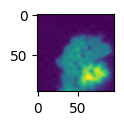

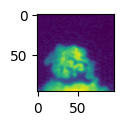

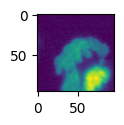

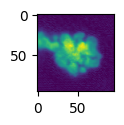

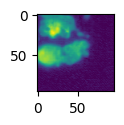

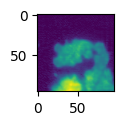

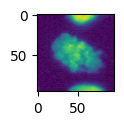

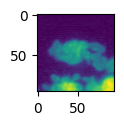

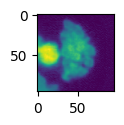

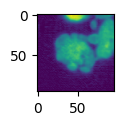

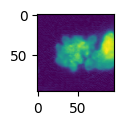

In [257]:
plot_n_images(transformed[:,:,:,2], 10,(1,1))

Check predictions of solidity

In [258]:
from cellpose import models, utils
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import regionprops, regionprops_table
from skimage.feature import graycomatrix, graycoprops

def compute_texture_features(image):
    # Compute GLCM
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(image, distances, angles, levels=256, symmetric=True, normed=True)
    
    # Compute texture properties
    contrast = graycoprops(glcm, 'contrast').mean()
    correlation = graycoprops(glcm, 'correlation').mean()
    energy = graycoprops(glcm, 'energy').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    
    return contrast, correlation, energy, homogeneity

def measure_nuclear_props(nuclear_images):
    # Initialize empty list 
    extent = []
    contrast= []
    correlation=[]
    energy=[] 
    homogeneity=[]
    
    for image in tqdm(nuclear_images):
        threshold_value = filters.threshold_otsu(image)
        binary_image = image > threshold_value
        
        # Label segmented regions
        model = models.Cellpose(gpu=True, model_type='cyto')  # gpu=True if you have GPU support
        masks, flows, styles, diams = model.eval(image, diameter=None, channels=[0,0])
        result = measure.regionprops_table(masks.astype(np.uint8), properties=("extent",))
        extent.append(result["extent"].mean())

        texture_fea = compute_texture_features((image*255).astype(np.uint8))
        contrast.append(texture_fea[0])
        correlation.append(texture_fea[1])
        energy.append(texture_fea[2])
        homogeneity.append(texture_fea[3])
                                               
    return extent, contrast, correlation, energy, homogeneity

In [259]:
solidity_df = {"Compound": [],
                "Measure": [],
                "Measure type": []}

for i, drugs in enumerate(["vincristine", "demecolcine", "nocodazole"]):
    controls_drug, transformed_drug = transform_by_id(solver, dataloader, 100, drugs, args)
    if i == 0:
        control_extent, control_contrast, control_correlation, control_energy, control_homogeneity = measure_nuclear_props(controls_drug[:100,:,:,2])
        solidity_df["Compound"] += ["DMSO" for _ in range(len(control_extent)*5)]
        solidity_df["Measure"] = solidity_df["Measure"] + control_extent + control_contrast + control_correlation + control_energy + control_homogeneity
        solidity_df["Measure type"] += ["Extent" for _ in range(len(control_extent))] + ["Contrast" for _ in range(len(control_contrast))] + ["Correlation" for _ in range(len(control_correlation))] + ["Energy" for _ in range(len(control_energy))] + ["Homogeneity" for _ in range(len(control_homogeneity))]
        
    drug_extent, drug_contrast, drug_correlation, drug_energy, drug_homogeneity  = measure_nuclear_props(transformed_drug[:100,:,:,2])
    solidity_df["Compound"] += [drugs for _ in range(len(drug_extent)*5)]
    solidity_df["Measure"] = solidity_df["Measure"] + drug_extent + control_contrast + drug_correlation + drug_energy + drug_homogeneity
    solidity_df["Measure type"] += ["Extent" for _ in range(len(drug_extent))] + ["Contrast" for _ in range(len(drug_contrast))] + ["Correlation" for _ in range(len(drug_correlation))] + ["Energy" for _ in range(len(drug_energy))] + ["Homogeneity" for _ in range(len(drug_homogeneity))]

100%|██████████| 100/100 [02:10<00:00,  1.31s/it]


In [260]:
for i in solidity_df:
    print(len(solidity_df[i]))

2000
2000
2000


In [261]:
solidity_df=pd.DataFrame(solidity_df)

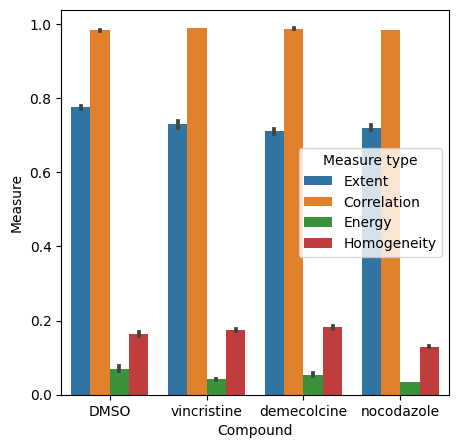

In [265]:
plt.figure(figsize=(5,5))
sns.barplot(data=solidity_df.loc[solidity_df["Measure type"]!="Contrast"], x="Compound", y="Measure", hue="Measure type")
plt.show()

In [263]:
solidity_df.loc[solidity_df["Measure type"]=="Eccentricity"]

,Compound,Measure,Measure type


In [242]:
# data_csv = pd.read_csv("../../../project_folder/datasets/bbbc021_six/metadata/bbbc021_df_six.csv", index_col=0)

In [245]:
# data_csv.STATE = ["control" if cpd=="DMSO" else "trt" for cpd in data_csv.CPD_NAME]

In [248]:
# data_csv.to_csv("../../../project_folder/datasets/bbbc021_six/metadata/bbbc021_df_six.csv")

In [244]:
# pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all_large/metadata/bbbc021_large.csv")

,Unnamed: 0,SAMPLE_KEY,BATCH,TABLE_NUMBER,IMAGE_NUMBER,OBJECT_NUMBER,CPD_NAME,SMILES,DOSE,ANNOT,STATE,split,SPLIT
0,0,Week1_22123_1_11_0,Week1_22123,1,11,0,cytochalasin B,C[C@@H]1CCC[C@@H](O)\\C=C\\C(=O)O[C@]23[C@@H](...,10.0,Actin disruptors,trt,train,train
1,1,Week1_22123_1_11_1,Week1_22123,1,11,1,cytochalasin B,C[C@@H]1CCC[C@@H](O)\\C=C\\C(=O)O[C@]23[C@@H](...,10.0,Actin disruptors,trt,test,test
2,2,Week1_22123_1_11_2,Week1_22123,1,11,2,cytochalasin B,C[C@@H]1CCC[C@@H](O)\\C=C\\C(=O)O[C@]23[C@@H](...,10.0,Actin disruptors,trt,train,train
3,3,Week1_22123_1_11_3,Week1_22123,1,11,3,cytochalasin B,C[C@@H]1CCC[C@@H](O)\\C=C\\C(=O)O[C@]23[C@@H](...,10.0,Actin disruptors,trt,train,train
4,4,Week1_22123_1_12_0,Week1_22123,1,12,0,cytochalasin B,C[C@@H]1CCC[C@@H](O)\\C=C\\C(=O)O[C@]23[C@@H](...,10.0,Actin disruptors,trt,train,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8203,8203,Week4_27542_4_719_3,Week4_27542,4,719,3,DMSO,CS(=O)C,0.0,DMSO,control,train,train
8204,8204,Week4_27542_4_720_0,Week4_27542,4,720,0,DMSO,CS(=O)C,0.0,DMSO,control,train,train
8205,8205,Week4_27542_4_720_1,Week4_27542,4,720,1,DMSO,CS(=O)C,0.0,DMSO,control,train,train
8206,8206,Week4_27542_4_720_2,Week4_27542,4,720,2,DMSO,CS(=O)C,0.0,DMSO,control,train,train
